In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    %matplotlib inline
    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

In [1]:
import pandas as pd
import os
import time
import numpy as np
import io
import requests
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/training"
#filename=os.path.join(path,"5class_100ms_file.csv")
#filename=os.path.join(path,"/home/iit/Desktop/project_mani/5classfet1.csv")
df=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/training/final_100ms.csv")
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
filename_write = os.path.join(path,"/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/training/4class_new100ms_write.csv")
#df=pd.read_csv(filename)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-2.177482,28.989668,13.514783,3.274898,0.596447,0.398882,-0.708436,3.897990,-2.568868,4.084522,-3.458008,3.329399,0.502433,AC & FAN
1,-2.217528,29.009960,14.496528,3.937856,0.885757,0.382850,-3.029734,3.721529,-1.249983,5.907419,-4.396610,5.099895,-0.134206,AC & FAN
2,-2.157077,29.629701,14.559298,3.647526,0.612399,1.271464,-3.784228,2.127398,-2.638736,3.369799,-3.730211,5.022815,1.037247,AC & FAN
3,-2.078407,29.166139,15.066271,3.693529,1.686593,0.728231,-3.368825,3.075890,-2.924258,5.053575,-1.145492,3.734177,1.093625,AC & FAN
4,-2.085620,29.093788,13.834518,3.553311,0.222944,-0.190377,-2.344441,4.263392,-1.810713,5.807317,-2.152727,1.521383,0.662543,AC & FAN


In [4]:
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)


In [5]:
# Encode to a 2D matrix for training
Label=encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20) 

In [7]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (2879855, 13)
Shape of y : (2879855, 4)
Shape of x_main : (2303884, 13)
Shape of x_holdout : (575971, 13)
Shape of y_main : (2303884, 4)
Shape of y_holdout : (575971, 4)


In [8]:
# Cross-validate
kf = KFold(5)
epochs=30
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))
for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
#####################################################################################    
# Training 
# Fully Connected Neural Network Model    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(50, activation='relu')) # Hidden 2
    model.add(Dense(25, activation='relu')) # Hidden 3
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto') 
    checkpointer = ModelCheckpoint(filepath="best_weights_myFNN_new4C_100ms.hdf5",
                               verbose=2,
                               save_best_only=True) # save best model

    start_time = time.time()
    history=model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],
                      verbose=0,batch_size=128,epochs=epochs)
    
    #################################################################################
    ## Testing 
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)
    
#############################################################################################
    
    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
#######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
####################################################################################################

    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    ##############################################



# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print("Final score (accuracy): {}".format(score))  

#######################################################################################################    

# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)

#####################################################################

model.summary()

Fold #1
Fold score (accuracy): 0.9724378603966778
Elapsed time: 0:14:42.56
Confusion matrix, without normalization
[[115383      0     21     12]
 [     5 111444   2276   1758]
 [    66   1308 110403   2988]
 [    16   1497   2753 110847]]
Fold #2
Fold score (accuracy): 0.9732517031015003
Elapsed time: 0:15:05.23
Confusion matrix, without normalization
[[115047      6     87     14]
 [     5 111740   2094   1715]
 [    22   1218 111073   2731]
 [    25   1429   2979 110592]]
Fold #3
Fold score (accuracy): 0.9720298539206601
Elapsed time: 0:15:18.78
Confusion matrix, without normalization
[[114665      0     17      6]
 [     8 110590   2246   2363]
 [   103   1174 110758   3531]
 [    40   1095   2305 111876]]
Fold #4
Fold score (accuracy): 0.9725984586904294
Elapsed time: 0:15:32.60
Confusion matrix, without normalization
[[115237      8     68     17]
 [     2 110606   2280   1842]
 [    33   1152 110922   3117]
 [    13   1288   2806 111386]]
Fold #5
Fold score (accuracy): 0.9734751

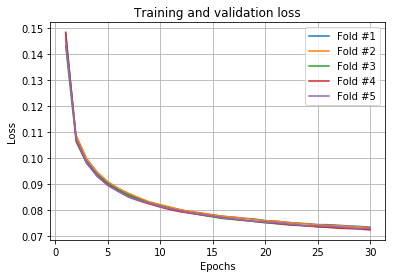

In [9]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("mani_4C_loss_100ms.eps")
plt.savefig("mani_4class_loss_100ms.png",dpi=150)
plt.show()

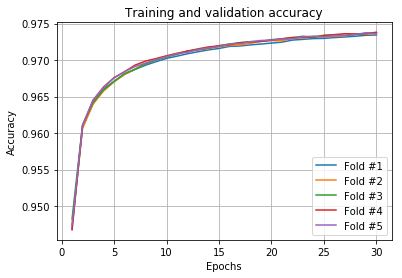

In [10]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("mani_k-fold_4C_acc_100ms.eps",dpi=150)
plt.savefig('mani_k-fold_4C_acc_100ms.png',dpi=150)
plt.show()

In [11]:
from keras.utils.vis_utils import plot_model
#import pydot
#import pydot as pydot
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model
plot_model(model, to_file='my_mani_100ms.png', show_shapes=True, show_layer_names=True)

Populating the interactive namespace from numpy and matplotlib


/home/bsplab/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


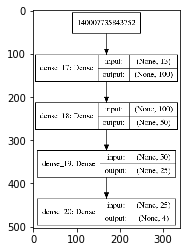

In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('my_mani_100ms.png')
imgplot = plt.imshow(img)
plt.show()
from PIL import Image
image = Image.open('my_mani_100ms.png')
image.show()


In [13]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

In [14]:
# Write the cross-validated prediction 
import time
tic = time.time()
holdout_pred = model.predict(x_holdout)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

11615.215063095093ms


In [15]:
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score of Holdout data: {}".format(score))

Log loss score of Holdout data: 0.07428555735780557


In [16]:
# Measure accuracy
holdout_pred = model.predict(x_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare, holdout_pred)
print("Holdout accuracy: {}".format(score))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Holdout accuracy: 0.9735976290472957
Elapsed time: 0:17:36.39


Confusion matrix, without normalization
[[143914     10    172     38]
 [     1 139933   2089   1554]
 [    42   1976 138531   3787]
 [    24   2297   3217 138386]]


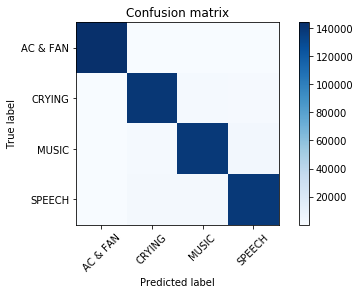

In [17]:


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_holdout_4C_myFNN_100ms.png',dpi=150)

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.97 0.01 0.01]
 [0.   0.01 0.96 0.03]
 [0.   0.02 0.02 0.96]]


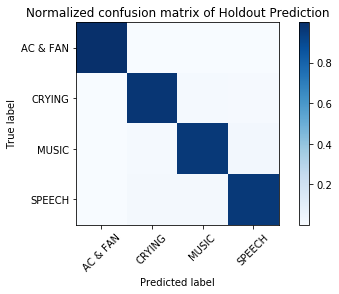

In [18]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, Label, title='Normalized confusion matrix of Holdout Prediction')
plt.savefig('norm_cm_holdout_4C_myFNN.png',dpi=150)
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred))  
print(classification_report(y_holdout_compare, holdout_pred))

[[143914     10    172     38]
 [     1 139933   2089   1554]
 [    42   1976 138531   3787]
 [    24   2297   3217 138386]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    144134
           1       0.97      0.97      0.97    143577
           2       0.96      0.96      0.96    144336
           3       0.96      0.96      0.96    143924

   micro avg       0.97      0.97      0.97    575971
   macro avg       0.97      0.97      0.97    575971
weighted avg       0.97      0.97      0.97    575971



Confusion matrix, without normalization


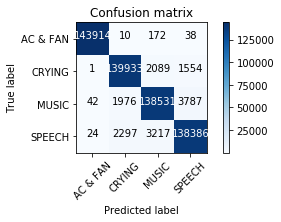

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix')

plt.savefig('kfold_fnn_mani_100ms.png')

In [21]:
[[C1,E1,N1,S1],[C2,E2,N2,S2],[C3,E3,N3,S3],[C4,E4,N4,S4]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  97.35976290472958
Precision:  97.35976290472958
Sensitivity/Recall:  97.35976290472958
Specificity:  97.35976290472958
Error Rate:  2.6402370952704257
F1-Score:  97.35976290472958


In [22]:
tic = time.time()
model.save('manikanta_FeedforwardNN_4class_100ms.h5')
toc = time.time()
print(str(1000*(toc-tic))+"ms")

1441.7243003845215ms


In [4]:
from keras.models import load_model
import time
tic = time.time()
loaded_mymodel= load_model('manikanta_FeedforwardNN_4class_100ms.h5')
toc = time.time()
print(str(1000*(toc-tic))+"ms")

967.0674800872803ms


In [5]:
df1=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/testing/cryingtest_100ms.csv')
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-11.532925,-41.439816,-10.013638,-5.886042,1.759984,5.037223,-7.673149,-9.511770,-16.812402,4.153761,10.477659,2.287526,-3.059897
1,-11.132136,-36.726535,-6.075866,-2.412740,3.656523,5.991037,-6.274219,-5.948665,-12.675685,3.190814,8.824465,1.740878,-4.977975
2,-10.583627,-40.753876,-7.334856,-3.710782,-0.050616,6.511381,-3.357559,-2.911659,-8.063696,2.940719,7.065572,2.832189,-4.986748
3,-10.230430,-42.837300,-9.278788,-3.923623,1.156336,8.304230,-2.481578,-2.876568,-7.910415,0.070745,2.850507,2.495628,-2.261219
4,-9.770289,-43.105286,-8.304959,-4.162195,2.176433,10.053204,-4.267742,-5.939098,-9.613048,1.381759,1.189527,2.285791,-3.813635


In [6]:

tic = time.time()
my_his=loaded_mymodel.predict(df1)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


4893.096685409546ms


(359981, 4)

In [7]:
test_pred = np.argmax(my_his, axis=1)
test_pred[150:380]
print(test_pred.shape)

(359981,)


In [8]:
test_pred.dtype

dtype('int64')

In [12]:
c =0
for i in  test_pred:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred.size/2:
    print("The tested audio is Crying")
else:
    print("Error")
       
        
print("Count is " + str(c))


    

The tested audio is Crying
Count is 244171


In [56]:
TP=sum(test_pred==1)
TP

244171

In [57]:
x=c/test_pred.size
print('Accuracy is for testing with new environment data of Crying:',100*x)

Accuracy is for testing with new environment data of Crying: 67.82885763415291


In [13]:
df2=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/testing/fanactest_100ms.csv')
df2.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df2.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-2.637563,24.946581,17.872302,10.035492,7.560951,5.714862,5.876867,8.588597,5.748936,7.415380,-0.742831,-0.504568,-1.272455
1,-2.723275,23.343048,17.831371,11.264676,9.598482,7.796808,5.982256,7.812995,4.369111,9.196586,2.676061,2.637595,0.246921
2,-2.771744,22.732348,17.301487,12.179611,8.277191,9.299631,5.213402,9.100486,3.375959,10.374525,1.115016,4.493698,-0.442079
3,-2.699598,23.024545,16.486434,12.787668,7.746319,10.687896,4.977225,11.660179,3.142948,12.912912,0.472647,5.822907,-1.500308
4,-2.706401,22.937800,16.808996,12.633535,7.895916,9.735795,4.626076,10.061706,2.381293,12.125506,0.093070,5.725651,-1.161997


In [14]:
tic = time.time()
my_his1=loaded_mymodel.predict(df2)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


5058.809280395508ms


(359981, 4)

In [15]:
test_pred1 = np.argmax(my_his1, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(359981,)


In [19]:
c =0
for i in  test_pred1:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is acfan")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is acfan
Count is 201888


In [62]:
sum(test_pred1==0)

201888

In [63]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of acfan:',100*x)

Accuracy is for testing with new environment data of acfan: 56.08295993399651


In [20]:
df3=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/testing/musictest_100ms.csv')
df3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df3.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.990123,-20.350678,-13.696701,3.631777,-31.725385,18.816110,-32.790862,2.403541,1.389364,-11.520431,18.829357,-2.981085,3.315220
1,-2.034620,-20.375766,-14.148921,3.194243,-31.738763,17.667094,-34.605984,2.908558,2.646545,-10.007036,19.021114,-1.875224,4.326378
2,-1.998620,-20.559211,-13.643551,4.088526,-31.637999,18.423230,-33.526329,3.590790,3.255856,-10.863344,18.494604,-1.581670,4.125259
3,-2.065147,-20.240945,-13.253146,5.043625,-30.390824,20.188941,-32.118361,4.604216,3.135303,-10.431314,15.644117,-2.382577,6.251958
4,-2.045668,-20.793000,-13.539983,4.327684,-31.059524,20.450706,-30.022440,6.100895,4.484121,-9.060196,17.732819,-2.039893,5.342894


In [21]:
tic = time.time()
my_his2=loaded_mymodel.predict(df3)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape

4918.700218200684ms


(359981, 4)

In [22]:
test_pred2 = np.argmax(my_his2, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(359981,)


In [26]:
c =0
for i in  test_pred2:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred2.size/2:
    print("The tested audio is Music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is Music
Count is 302889


In [68]:
x=c/test_pred2.size
print('Accuracy is for testing with new environment data of Music:',100*x)

Accuracy is for testing with new environment data of Music: 84.14027407002035


In [27]:
df4=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/100ms/testing/speechtest_100ms.csv')
df4.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df4.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-0.050201,-1.459950,-47.080772,-7.018598,-11.433996,-20.761678,-12.831117,-0.354264,3.782690,-34.074036,-3.161392,-7.593636,-11.672030
1,-0.222368,-1.292799,-46.186094,-8.490439,-10.644840,-21.136131,-12.568691,0.842650,2.782625,-32.947479,-4.579298,-9.013817,-12.850303
2,-0.371657,0.892316,-42.921003,-3.493762,-5.445394,-14.351058,-4.787823,8.354385,10.320699,-26.221010,3.089642,-4.833432,-8.600031
3,-0.513524,-2.672771,-44.943169,-7.844133,-9.566689,-20.073346,-11.331026,1.852691,3.706034,-28.943520,-2.017533,-9.360505,-15.007542
4,-0.971738,-0.565293,-42.097997,-7.001646,-9.542562,-19.810856,-11.306753,1.330879,2.200913,-29.802182,0.201652,-10.412355,-14.063427


In [28]:
tic = time.time()
my_his3=loaded_mymodel.predict(df4)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape

5184.235334396362ms


(359981, 4)

In [29]:
test_pred3 = np.argmax(my_his3, axis=1)
test_pred3[150:380]
print(test_pred3.shape)

(359981,)


In [33]:
c =0
for i in  test_pred3:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred3.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 329146


In [74]:
x=c/test_pred3.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 91.43427014203527


In [47]:
sum(test_pred3==3)

2